### Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# API/Data
from pybaseball import statcast, pitching_stats, statcast_pitcher, playerid_lookup
import pybaseball

import xgboost as xgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error, r2_score

### Data

In [20]:
# pybaseball statcast
start_date = '2023-03-29'
end_date = '2023-10-02'
pybaseball.cache.enable()
statcast_data = statcast(start_dt = start_date, end_dt = end_date) # Comment it when rerunning this block

# Pitch data
selected_columns = ['player_name', 'pitch_name', 'description', 'release_speed', 'release_pos_x', 'release_pos_z', 'p_throws',
                    'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ax', 'az', 
                    'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y',  'spin_axis', 'delta_run_exp']

pitch = statcast_data[selected_columns]
pitch.shape

# Whiff%
total_swing = ['hit_into_play', 'foul', 'swinging_strike', 'foul_tip', 'swinging_strike_blocked', 'foul_bunt', 'missed_bunt', 'bunt_foul_tip']
missed_swing = ['swinging_strike', 'swinging_strike_blocked', 'missed_bunt']

pitch = pitch[pitch['description'].isin(total_swing)]
pitch['whiff'] = pitch['description'].apply(lambda x: 1 if x in missed_swing else 0)

# Drop NA
na_counts = pitch.isna().sum()
na_counts_list = [(column, na_count) for column, na_count in na_counts.items()]
pitch = pitch.dropna()

# Drop pitch types with small size
temp = ['Slurve', 'Other', 'Forkball', 'Eephus', 'Knuckleball', 'Screwball', 'Slow Curve']
pitch = pitch[~pitch['pitch_name'].isin(temp)]
pitch['p_throws'] = pitch['p_throws'].apply(lambda x: 1 if x == 'R' else 0)

# Data frame for each pitch type
grouped = pitch.groupby('pitch_name')
dataframes = {}
for p, group in grouped:
    dataframes[p] = group

This is a large query, it may take a moment to complete


100%|██████████| 188/188 [00:12<00:00, 14.53it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\pybaseball\statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


dict_keys(['4-Seam Fastball', 'Changeup', 'Curveball', 'Cutter', 'Knuckle Curve', 'Sinker', 'Slider', 'Split-Finger', 'Sweeper'])

### Modeling

In [4]:
test_ff = dataframes['4-Seam Fastball']

X = test_ff[['release_speed', 'release_pos_x', 'release_pos_z', 'p_throws', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 
           'vx0', 'vy0', 'vz0', 'ax', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis']]
y = test_ff['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to numpy
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

#### XGBoost Test Code

In [5]:
# XGBoost Model
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    reg_alpha=0,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit Model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Predicted probabilities:", y_pred_proba[:10])
y_pred_proba.shape

Accuracy: 0.81
Predicted probabilities: [0.05636713 0.15909287 0.46006218 0.4897924  0.12310395 0.29569244
 0.18570337 0.36125004 0.22007893 0.08405063]


(33196,)

#### Stuff+ using Logistic Regression

In [25]:
def stuff_plus_log(pitch_data):
    X = pitch_data[['release_speed', 'release_pos_x', 'release_pos_z', 'p_throws', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 
                    'vx0', 'vy0', 'vz0', 'ax', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis']]
    y = pitch_data['whiff']


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = LogisticRegression(max_iter=500, solver='saga')
    model.fit(X_scaled, y)


    pitch_data['stuff+'] = model.predict_proba(X_scaled)[:, 1]
    league_average = pitch_data['stuff+'].mean()
    pitch_data['stuff+'] = (pitch_data['stuff+'] / league_average) * 100

    return pitch_data

In [29]:
test_ff = dataframes['4-Seam Fastball']
test_ff = stuff_plus_log(test_ff)

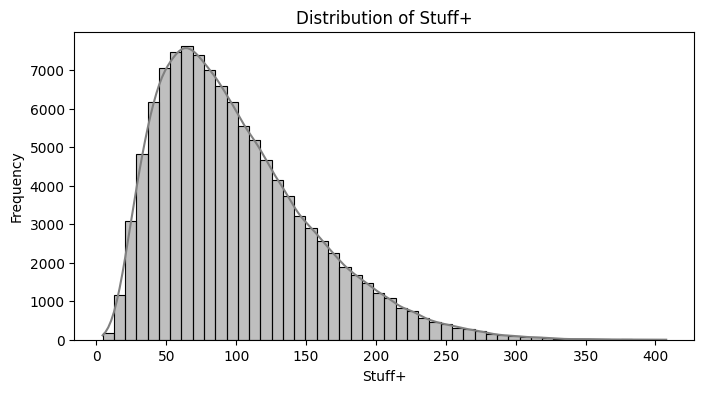

In [35]:
plot_stuff_plus_distribution(test_ff)

#### Stuff+ using XGBoost

In [7]:
def stuff_plus_XGBoost(pitch_data):
    X = pitch_data[['release_speed', 'release_pos_x', 'release_pos_z', 'p_throws', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 
                    'vx0', 'vy0', 'vz0', 'ax', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis']]
    y = pitch_data['whiff']

    X = X.values
    y = y.values

    # Data Scaling *Optional for XGBoost
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    # XGBoost Model
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X, y)

    # Stuff+
    pitch_data['stuff+'] = model.predict_proba(X)[:, 1]
    league_average = pitch_data['stuff+'].mean()
    pitch_data['stuff+'] = (pitch_data['stuff+'] / league_average) * 100

    return pitch_data

#### Stuff+ using Random Forest

In [8]:
def stuff_plus_rf(pitch_data):

    X = pitch_data[['release_speed', 'release_pos_x', 'release_pos_z', 'p_throws', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 
                    'vx0', 'vy0', 'vz0', 'ax', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis']]
    y = pitch_data['whiff']

    # X = X.values
    # y = y.values

    # RandomForest
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X, y)

    # Stuff+ 
    pitch_data['stuff+'] = model.predict_proba(X)[:, 1]
    league_average = pitch_data['stuff+'].mean()
    pitch_data['stuff+'] = (pitch_data['stuff+'] / league_average) * 100

    return pitch_data

#### Stuff+ Data

In [47]:
pitch_types = ['4-Seam Fastball', 'Changeup', 'Curveball', 'Cutter', 'Knuckle Curve', 'Sinker', 'Slider', 'Split-Finger', 'Sweeper']
log_df = {}
xgb_df = {}
rf_df = {}

for pitch in pitch_types:
    log_df[pitch] = stuff_plus_log(dataframes[pitch])



#### Stuff+ Plot

In [122]:
def plot_stuff_plus_distribution(df, pitch):
    # Define the mapping of pitch to pitch name inside the function
    pitch_name_mapping = {
        '4-Seam Fastball': 'Fastball',
        'Changeup': 'Changeup',
        'Curveball': 'Curveball',
        'Cutter': 'Cutter',
        'Knuckle Curve': 'Knuckle Curve',
        'Sinker': 'Sinker',
        'Slider': 'Slider',
        'Split-Finger': 'Split-Finger',
        'Sweeper': 'Sweeper'
    }
    
    pitch_name = pitch_name_mapping.get(pitch, 'Unknown Pitch')
    
    plt.figure(figsize=(5, 5))
    sns.histplot(df['stuff+'], bins=50, kde=True, color='gray')
    plt.title(f'Stuff+ Distribution of {pitch_name}')
    plt.xlabel('Stuff+')
    plt.ylabel('Frequency')
    plt.show()

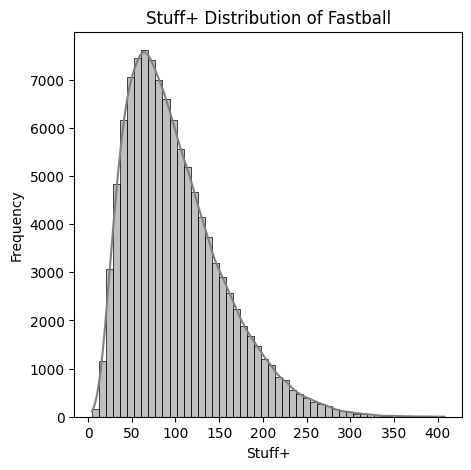

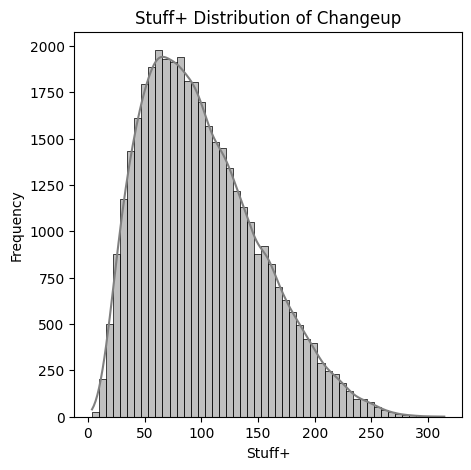

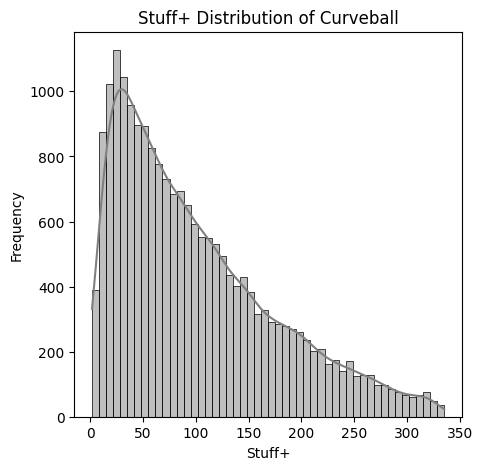

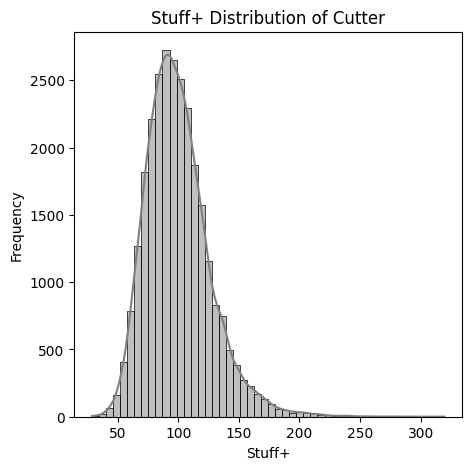

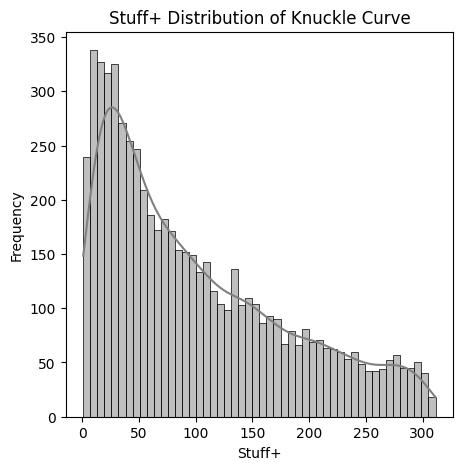

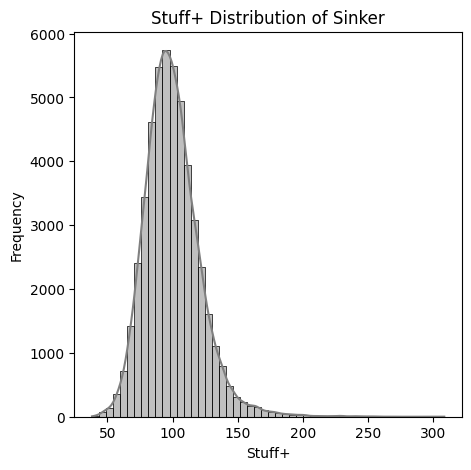

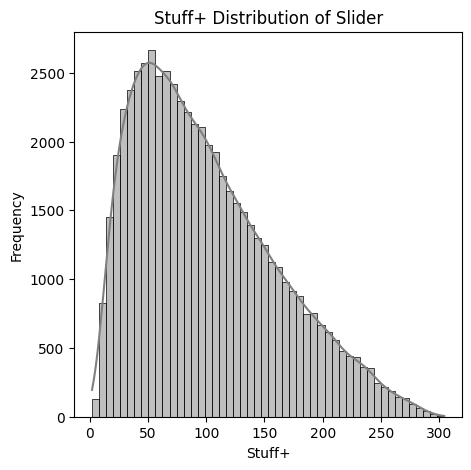

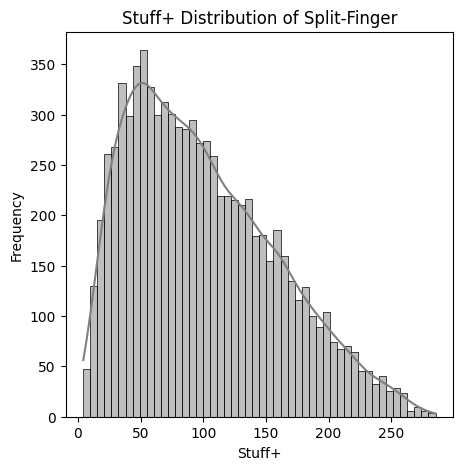

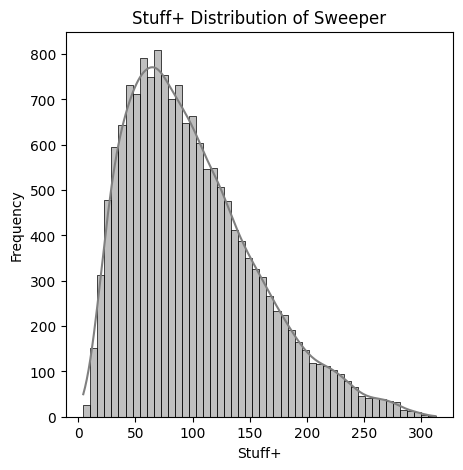

In [123]:
for pitch in pitch_types:
    plot_stuff_plus_distribution(log_df[pitch], pitch)

#### Stuff+ for Each Pitcher

In [130]:
fastball = log_df['4-Seam Fastball']
changeup = log_df['Changeup']
curveball = log_df['Curveball']
cutter = log_df['Cutter']
knuckle = log_df['Knuckle Curve']
sinker = log_df['Sinker']
slider = log_df['Slider']
spliter = log_df['Split-Finger']
sweeper = log_df['Sweeper']

fast_pit = fastball.groupby('player_name')['stuff+'].mean().reset_index()
chan_pit = changeup.groupby('player_name')['stuff+'].mean().reset_index()
curve_pit = curveball.groupby('player_name')['stuff+'].mean().reset_index()
cut_pit = cutter.groupby('player_name')['stuff+'].mean().reset_index()
knuckle_pit = knuckle.groupby('player_name')['stuff+'].mean().reset_index()
sink_pit = sinker.groupby('player_name')['stuff+'].mean().reset_index()
slide_pit = slider.groupby('player_name')['stuff+'].mean().reset_index()
split_pit = spliter.groupby('player_name')['stuff+'].mean().reset_index()
sweep_pit = sweeper.groupby('player_name')['stuff+'].mean().reset_index()

In [136]:
fast_pit.sort_values(by='stuff+', ascending=False, inplace=True)
chan_pit
curve_pit

,player_name,stuff+
0,"Abbott, Andrew",100.487791
1,"Adon, Joan",79.673831
2,"Alcantara, Sandy",107.679412
3,"Allard, Kolby",91.683849
4,"Anderson, Chase",60.985592
...,...,...
313,"Yarbrough, Ryan",93.750056
314,"Young, Alex",95.576782
315,"Zastryzny, Rob",90.747250
316,"Zimmermann, Bruce",104.806838


In [ ]:
plot_stuff_plus_distribution(fast_pit, '4-Seam Fastball')
plot_stuff_plus_distribution(chan_pit, 'Changeup')
plot_stuff_plus_distribution(curve_pit, 'Curveball')
plot_stuff_plus_distribution(cut_pit, 'Cutter')
plot_stuff_plus_distribution(knuckle_pit, 'Knuckle Curve')
plot_stuff_plus_distribution(sink_pit, 'Sinker')
plot_stuff_plus_distribution(slide_pit, 'Slider')
plot_stuff_plus_distribution(split_pit, 'Split-Finger')
plot_stuff_plus_distribution(sweep_pit, 'Sweeper')

### Stuff+ of Five Pitchers

In [52]:
log_df.keys()

dict_keys(['4-Seam Fastball', 'Changeup', 'Curveball', 'Cutter', 'Knuckle Curve', 'Sinker', 'Slider', 'Split-Finger', 'Sweeper'])

In [138]:
# log_df is a dict with data frames

fastball = log_df['4-Seam Fastball']
changeup = log_df['Changeup']
curveball = log_df['Curveball']
cutter = log_df['Cutter']
knuckle = log_df['Knuckle Curve']
sinker = log_df['Sinker']
slider = log_df['Slider']
spliter = log_df['Split-Finger']
sweeper = log_df['Sweeper']

pitchers = ['Abbott, Andrew', 'Corbin, Patrick', 'Scherzer, Max', 'Darvish, Yu', 'Sears, JP']

fastball_stuffp = []
changeup_stuffp = []
curveball_stuffp = []
cutter_stuffp = []
knuckle_stuffp = []
sinker_stuffp = []
slider_stuffp = []
spliter_stuffp = []
sweeper_stuffp = []


for pitcher in pitchers:
    fastball_mean = fastball[fastball['player_name'] == pitcher]['stuff+'].mean(skipna=True)
    changeup_mean = changeup[changeup['player_name'] == pitcher]['stuff+'].mean(skipna=True)
    curveball_mean = curveball[curveball['player_name'] == pitcher]['stuff+'].mean(skipna=True)
    cutter_mean = cutter[cutter['player_name'] == pitcher]['stuff+'].mean(skipna=True)
    knuckle_mean = knuckle[knuckle['player_name'] == pitcher]['stuff+'].mean(skipna=True)
    sinker_mean = sinker[sinker['player_name'] == pitcher]['stuff+'].mean(skipna=True)
    slider_mean = slider[slider['player_name'] == pitcher]['stuff+'].mean(skipna=True)
    spliter_mean = spliter[spliter['player_name'] == pitcher]['stuff+'].mean(skipna=True)
    sweeper_mean = sweeper[sweeper['player_name'] == pitcher]['stuff+'].mean(skipna=True)

    fastball_stuffp.append(round(fastball_mean) if not pd.isna(fastball_mean) else 0)
    changeup_stuffp.append(round(changeup_mean) if not pd.isna(changeup_mean) else 0)
    curveball_stuffp.append(round(curveball_mean) if not pd.isna(curveball_mean) else 0)
    cutter_stuffp.append(round(cutter_mean) if not pd.isna(cutter_mean) else 0)
    knuckle_stuffp.append(round(knuckle_mean) if not pd.isna(knuckle_mean) else 0)
    sinker_stuffp.append(round(sinker_mean) if not pd.isna(sinker_mean) else 0)
    slider_stuffp.append(round(slider_mean) if not pd.isna(slider_mean) else 0)
    spliter_stuffp.append(round(spliter_mean) if not pd.isna(spliter_mean) else 0)
    sweeper_stuffp.append(round(sweeper_mean) if not pd.isna(sweeper_mean) else 0)

In [139]:
stuff_df = {
    'Pitcher': pitchers,
    '4-Seam Fastball': fastball_stuffp,
    'Changeup': changeup_stuffp,
    'Curveball': curveball_stuffp,
    'Cutter': cutter_stuffp,
    'Knuckle Curve': knuckle_stuffp,
    'Sinker': sinker_stuffp,
    'Slider': slider_stuffp,
    'Split-Finger': spliter_stuffp,
    'Sweeper': sweeper_stuffp
}

stuff_df = pd.DataFrame(stuff_df)
stuff_df = stuff_df.set_index('Pitcher').transpose()

stuff_df

Pitcher,"Abbott, Andrew","Corbin, Patrick","Scherzer, Max","Darvish, Yu","Sears, JP"
4-Seam Fastball,106,67,106,117,111
Changeup,87,128,90,0,80
Curveball,100,0,108,96,0
Cutter,0,0,118,103,0
Knuckle Curve,0,0,0,90,0
Sinker,0,104,0,103,117
Slider,0,133,116,90,85
Split-Finger,0,0,0,93,0
Sweeper,113,0,0,84,82
